## Code Modules

In [1]:
import pandas as pd,numpy as np,pylab as pl
import os,h5py,cv2,tensorflow as tf
import tensorflow_hub as th
from sklearn.model_selection import train_test_split
fpath='../input/image-classification-for-biospecies/'
fw='weights.best.hdf5'

## Data

['test_images', 'test_labels', 'train_images', 'train_labels']


,train,valid,test
image shape,"(12000, 128, 128, 3)","(4290, 128, 128, 3)","(4290, 128, 128, 3)"
image type,float32,float32,float32
label shape,"(12000, 1)","(4290, 1)","(4290, 1)"
label type,int32,int32,int32
shape of encoded label,"(12000, 120)","(4290, 120)","(4290, 120)"
type of encoded label,int32,int32,int32


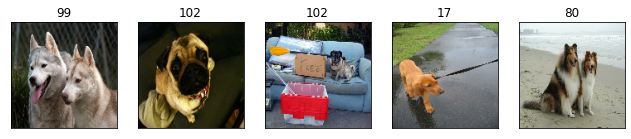

In [2]:
f=h5py.File(fpath+'DogBreedImages.h5','r')
keys=list(f.keys()); print(keys)
x_test=np.array(f[keys[0]]); y_test=np.array(f[keys[1]])
x_train=np.array(f[keys[2]]); y_train=np.array(f[keys[3]])
fig=pl.figure(figsize=(11,4))
n=np.random.randint(1,50); n_classes=120
for i in range(n,n+5):
    ax=fig.add_subplot(1,5,i-n+1,\
    xticks=[],yticks=[],title=y_test[i][0])
    ax.imshow((x_test[i]))
cy_train=np.array(tf.keras.utils\
.to_categorical(y_train,n_classes),dtype='int32')
cy_test=np.array(tf.keras.utils\
.to_categorical(y_test,n_classes),dtype='int32')
n=int(len(x_test)/2)
x_valid,y_valid,cy_valid=x_test[:n],y_test[:n],cy_test[:n]
x_test,y_test,cy_test=x_test[n:],y_test[n:],cy_test[n:]
df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                 [x_train.dtype,x_valid.dtype,x_test.dtype],
                 [y_train.shape,y_valid.shape,y_test.shape],
                 [y_train.dtype,y_valid.dtype,y_test.dtype],
                 [cy_train.shape,cy_valid.shape,cy_test.shape],
                 [cy_train.dtype,cy_valid.dtype,cy_test.dtype]],
                 columns=['train','valid','test'],
                 index=['image shape','image type',
                        'label shape','label type',
                        'shape of encoded label',
                        'type of encoded label'])
display(df) 

## NN Examples
mobilenet_v1_100_128

In [3]:
def premodel(pix,den,mh,lbl):
    model=tf.keras.Sequential([
        tf.keras.layers.Input((pix,pix,3),
                              name='input'),
        th.KerasLayer(mh,trainable=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(den,activation='relu'),
        tf.keras.layers.Dropout(rate=.5),
        tf.keras.layers.Dense(lbl,activation='softmax')])
    model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy')
    display(model.summary())
    return model
def cb(fw):
    early_stopping=tf.keras.callbacks\
    .EarlyStopping(monitor='val_loss',patience=20,verbose=2)
    checkpointer=tf.keras.callbacks\
    .ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
    lr_reduction=tf.keras.callbacks\
    .ReduceLROnPlateau(monitor='val_loss',verbose=2,
                       patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]


In [4]:
[handle_base,pixels]=["mobilenet_v1_100_128",128]
mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
.format(handle_base)
fw='weights.best.hdf5'

In [5]:
model=premodel(pixels,1024,mhandle,120)
history=model.fit(x=x_train,y=y_train,batch_size=128,
                  epochs=25,callbacks=cb(fw),
                  validation_data=(x_valid,y_valid))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1024)              3228864   
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               123000    
Total params: 4,401,464
Trainable params: 4,379,576
Non-trainable params: 21,888
_________________________________________________________________


None

Train on 12000 samples, validate on 4290 samples
Epoch 1/25
11904/12000 [============================>.] - ETA: 0s - loss: 3.3282 - accuracy: 0.2475
Epoch 00001: val_loss improved from inf to 3.83605, saving model to weights.best.hdf5
12000/12000 [==============================] - 25s 2ms/sample - loss: 3.3223 - accuracy: 0.2480 - val_loss: 3.8361 - val_accuracy: 0.1830
Epoch 2/25
11904/12000 [============================>.] - ETA: 0s - loss: 1.9258 - accuracy: 0.5051
Epoch 00002: val_loss improved from 3.83605 to 2.37767, saving model to weights.best.hdf5
12000/12000 [==============================] - 18s 1ms/sample - loss: 1.9255 - accuracy: 0.5049 - val_loss: 2.3777 - val_accuracy: 0.4000
Epoch 3/25
11904/12000 [============================>.] - ETA: 0s - loss: 1.4121 - accuracy: 0.6281
Epoch 00003: val_loss did not improve from 2.37767
12000/12000 [==============================] - 17s 1ms/sample - loss: 1.4125 - accuracy: 0.6280 - val_loss: 2.3880 - val_accuracy: 0.4186
Epoch 4/25

In [6]:
model.load_weights(fw)
model.evaluate(x_test,y_test)

4290/4290 [==============================] - 2s 370us/sample - loss: 2.4374 - accuracy: 0.3851


[2.4374405049499654, 0.3850816]

inception_resnet_v2

In [7]:
[handle_base,pixels]=["inception_resnet_v2",128]
mhandle="https://tfhub.dev/google/imagenet/{}/classification/4"\
.format(handle_base)
fw='weights.best.hdf5'

In [8]:
model=premodel(pixels,512,mhandle,120)
history=model.fit(x=x_train,y=y_train,batch_size=64,
                  epochs=10,callbacks=cb(fw),
                  validation_data=(x_valid,y_valid))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              55875273  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1001)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               513024    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               61560     
Total params: 56,449,857
Trainable params: 56,389,313
Non-trainable params: 60,544
_________________________________________________________________


None

Train on 12000 samples, validate on 4290 samples
Epoch 1/10
11968/12000 [============================>.] - ETA: 0s - loss: 5.4309 - accuracy: 0.0133
Epoch 00001: val_loss improved from inf to 5.28320, saving model to weights.best.hdf5
12000/12000 [==============================] - 88s 7ms/sample - loss: 5.4302 - accuracy: 0.0134 - val_loss: 5.2832 - val_accuracy: 0.0259
Epoch 2/10
11968/12000 [============================>.] - ETA: 0s - loss: 4.8792 - accuracy: 0.0458
Epoch 00002: val_loss did not improve from 5.28320
12000/12000 [==============================] - 53s 4ms/sample - loss: 4.8785 - accuracy: 0.0458 - val_loss: 162.3258 - val_accuracy: 0.0569
Epoch 3/10
11968/12000 [============================>.] - ETA: 0s - loss: 4.3824 - accuracy: 0.0916
Epoch 00003: val_loss improved from 5.28320 to 4.85015, saving model to weights.best.hdf5
12000/12000 [==============================] - 58s 5ms/sample - loss: 4.3822 - accuracy: 0.0918 - val_loss: 4.8501 - val_accuracy: 0.0664
Epoch 4/

In [9]:
model.load_weights(fw)
model.evaluate(x_test,y_test)

4290/4290 [==============================] - 8s 2ms/sample - loss: 3.4346 - accuracy: 0.3161


[3.434585039654534, 0.3160839]